In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import math

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn import preprocessing

## Steps

## Exploratory Data Analysis and Features Engineering

In [5]:
#first of all, we need to import the data and parse the features that indicate dates into timestamp objects

df_raw = pd.read_csv('./Final_dataset.csv', parse_dates = ['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
df_raw.head()

# fare_amount --> amount indicated by the meter

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,total_amount,congestion_surcharge,PU_zone,PU_borough,PU_latitude,PU_longitude,DO_zone,DO_borough,DO_latitude,DO_longitude
0,0,1.0,2020-01-21 18:48:44,2020-01-21 19:08:40,2.0,4.80,1.0,N,137,256,...,22.8,2.5,Kips Bay,Manhattan,40.739546,-73.977083,Williamsburg (South Side),Brooklyn,40.710732,-73.943609
1,1,2.0,2020-01-12 04:08:39,2020-01-12 04:10:16,1.0,0.57,1.0,N,107,107,...,7.3,2.5,Gramercy,Manhattan,40.735519,-73.984079,Gramercy,Manhattan,40.735519,-73.984079
2,2,1.0,2020-01-27 12:12:33,2020-01-27 12:21:34,1.0,0.90,1.0,Y,137,164,...,11.3,2.5,Kips Bay,Manhattan,40.739546,-73.977083,Midtown South,Manhattan,40.749842,-73.984251
3,3,1.0,2020-01-31 09:55:46,2020-01-31 10:07:18,1.0,1.80,1.0,N,141,143,...,13.8,2.5,Lenox Hill West,Manhattan,40.769382,-73.959474,Lincoln Square West,Manhattan,40.771060,-73.980557
4,4,2.0,2020-01-24 00:24:09,2020-01-24 00:47:14,1.0,9.06,1.0,N,138,90,...,44.9,2.5,LaGuardia Airport,Queens,40.775714,-73.873364,Flatiron,Manhattan,40.741059,-73.989642


In [6]:
#let's pick just the features we are interested in

columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'tip_amount', 'total_amount']
df = df_raw[columns]
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,tip_amount,total_amount
0,2020-01-21 18:48:44,2020-01-21 19:08:40,2.0,4.80,137,256,2.0,0.00,22.8
1,2020-01-12 04:08:39,2020-01-12 04:10:16,1.0,0.57,107,107,1.0,0.00,7.3
2,2020-01-27 12:12:33,2020-01-27 12:21:34,1.0,0.90,137,164,1.0,1.00,11.3
3,2020-01-31 09:55:46,2020-01-31 10:07:18,1.0,1.80,141,143,1.0,1.00,13.8
4,2020-01-24 00:24:09,2020-01-24 00:47:14,1.0,9.06,138,90,1.0,7.48,44.9


In [7]:
df.groupby(df.payment_type).payment_type.count()

# 1 --> credit card
# 2 --> cash
# 3 --> no charge (nessun addebbito)
# 4 --> dispute (controversia, in disaccordo)
# 5 --> unkown
# 6 --> voided trip

#the type of payment 1.0 (credit card) and 2.0 (cash) are the most frequent, therefore we'll consider just those 2

payment_type
1.0    63939
2.0    24056
3.0      663
4.0      367
Name: payment_type, dtype: int64

In [8]:
df.groupby(df.PULocationID).payment_type.count()

#the (pick up or drop off) location ID can be different for the same borough (Manhattan, Brookyin, Bronx etc.) 

PULocationID
1         6
3         2
4        93
5         1
6         1
       ... 
261     310
262    1463
263    2605
264     666
265      55
Name: payment_type, Length: 247, dtype: int64

In [9]:
#let's pick just the records for which the payment is payment type is credit card or cash and the passenger is at least one

df = df[((df.payment_type == 1.0) | (df.payment_type == 2.0)) & (df.passenger_count != 0.0)]
df.groupby(df.passenger_count).passenger_count.count()

#check
df.groupby(df.payment_type).payment_type.count()

payment_type
1.0    62593
2.0    23539
Name: payment_type, dtype: int64

In [10]:
#taxi+_zone_lookup.csv contains information about the pick up and drop off locations IDs; given that we'd like to focus on the 
#boroughs of Manhattan and Brooklyn, we create 2 lists containing list_man and list_bro containing respectively the IDs
#corresponding to the boroughs of Manhattan and Brooklyn 

zone = pd.read_csv('./Taxi_Zone_Lookup_Fixed.csv')

MAN = zone[(zone.borough == 'Manhattan' )]
BRO = zone[(zone.borough == 'Brooklyn' )]

list_man = MAN['LocationID'].tolist()
list_bro = BRO['LocationID'].tolist()

In [11]:
#we then convert the values of the PULocationID feature in 1 if the ID corresponds to one of Manhattan's IDs, in 0 if the ID
#corresponds to one of Brooklyn's IDs and in 2 otherwise

list_PULocationID = df['PULocationID'].tolist()

array = np.array([])

for element in list_PULocationID:

    if element in list_man:
        
        #Manhattan = 1
        array = np.append(array, 1)
    
    elif element in list_bro:
        
        #Brooklyn = 0
        array = np.append(array, 0)
        
    else:
        
        array = np.append(array, 2)
        
#check
len(array) == df.shape[0]

True

In [12]:
df.PULocationID = array
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,tip_amount,total_amount
0,2020-01-21 18:48:44,2020-01-21 19:08:40,2.0,4.80,1.0,256,2.0,0.00,22.8
1,2020-01-12 04:08:39,2020-01-12 04:10:16,1.0,0.57,1.0,107,1.0,0.00,7.3
2,2020-01-27 12:12:33,2020-01-27 12:21:34,1.0,0.90,1.0,164,1.0,1.00,11.3
3,2020-01-31 09:55:46,2020-01-31 10:07:18,1.0,1.80,1.0,143,1.0,1.00,13.8
4,2020-01-24 00:24:09,2020-01-24 00:47:14,1.0,9.06,2.0,90,1.0,7.48,44.9


In [13]:
#same for the DOLocationID feature

list_DOLocationID = df['DOLocationID'].tolist()

array1 = np.array([])

for element in list_DOLocationID:

    if element in list_man:
        
        #Manhattan = 1
        array1 = np.append(array1, 1)
    
    elif element in list_bro:
        
        #Brooklyn = 0
        array1 = np.append(array1, 0)
        
    else:
        
        array1 = np.append(array1, 2)
        
#check
len(array1) == df.shape[0]

True

In [14]:
df.DOLocationID = array1
df.head()


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,tip_amount,total_amount
0,2020-01-21 18:48:44,2020-01-21 19:08:40,2.0,4.80,1.0,0.0,2.0,0.00,22.8
1,2020-01-12 04:08:39,2020-01-12 04:10:16,1.0,0.57,1.0,1.0,1.0,0.00,7.3
2,2020-01-27 12:12:33,2020-01-27 12:21:34,1.0,0.90,1.0,1.0,1.0,1.00,11.3
3,2020-01-31 09:55:46,2020-01-31 10:07:18,1.0,1.80,1.0,1.0,1.0,1.00,13.8
4,2020-01-24 00:24:09,2020-01-24 00:47:14,1.0,9.06,2.0,1.0,1.0,7.48,44.9


In [15]:
#pick just the records for which the PULocationID is 0 (Brooklyn) or 1 (Manhattan) 

df = df[(df.PULocationID == 0.0) | (df.PULocationID == 1.0)]
len(df)

80962

In [16]:
df = df.reset_index()
df = df.drop(['index'], axis=1)
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,tip_amount,total_amount
0,2020-01-21 18:48:44,2020-01-21 19:08:40,2.0,4.80,1.0,0.0,2.0,0.00,22.80
1,2020-01-12 04:08:39,2020-01-12 04:10:16,1.0,0.57,1.0,1.0,1.0,0.00,7.30
2,2020-01-27 12:12:33,2020-01-27 12:21:34,1.0,0.90,1.0,1.0,1.0,1.00,11.30
3,2020-01-31 09:55:46,2020-01-31 10:07:18,1.0,1.80,1.0,1.0,1.0,1.00,13.80
4,2020-01-14 23:51:36,2020-01-14 23:58:55,2.0,1.37,1.0,1.0,1.0,2.26,13.56


In [17]:
#add a new feature 'time_distance' given by the difference between the time the passenger was picked up and dropped off

df['time_distance'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime

#check
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,time_distance
0,2020-01-21 18:48:44,2020-01-21 19:08:40,2.0,4.80,1.0,0.0,2.0,0.00,22.80,0 days 00:19:56
1,2020-01-12 04:08:39,2020-01-12 04:10:16,1.0,0.57,1.0,1.0,1.0,0.00,7.30,0 days 00:01:37
2,2020-01-27 12:12:33,2020-01-27 12:21:34,1.0,0.90,1.0,1.0,1.0,1.00,11.30,0 days 00:09:01
3,2020-01-31 09:55:46,2020-01-31 10:07:18,1.0,1.80,1.0,1.0,1.0,1.00,13.80,0 days 00:11:32
4,2020-01-14 23:51:36,2020-01-14 23:58:55,2.0,1.37,1.0,1.0,1.0,2.26,13.56,0 days 00:07:19


In [18]:
type(df.time_distance[0])

pandas._libs.tslibs.timedeltas.Timedelta

In [19]:
for i in range(len(df)):
    
    df.time_distance[i] = df.time_distance[i].seconds

## Analysis of features for Linear Regression

The goal of our linear regression model is to predict the tip_amount that the taxy rider will receive, based on the characteristics of his ride. To this end, we analyze the different features one by one comparing them with tip_amount (target variable), discovering correlations and general relationships

### Total amount & Trip distance vs Tip amount

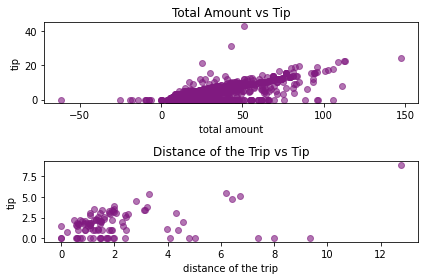

In [20]:
#compare the trend of the total amount paid by the passenger and the distance of the trip (in miles) both wrt the amount of the 
#tip

plt.figure()

plt.subplot(211)
plt.scatter(df.total_amount[0:10000], df.tip_amount[0:10000], color = (0.5,0.1,0.5,0.6))
plt.title('Total Amount vs Tip')
plt.xlabel('total amount')
plt.ylabel('tip')

plt.subplot(212)
plt.scatter(df.trip_distance[0:100], df.tip_amount[0:100], color = (0.5,0.1,0.5,0.6))
plt.title('Distance of the Trip vs Tip')
plt.xlabel('distance of the trip')
plt.ylabel('tip')
plt.tight_layout()

plt.show()

In [21]:
#we can see a positive trend, that can be confirmed also via the calculation of the correlation coefficient

print('The correlation between the total amount and the amount of the tip is '+ str(round(np.corrcoef(df['total_amount'], \
       df['tip_amount'])[0][1], 2)))
print('The correlation between the distance of the trip and the amount of the tip is '+ str(round(np.corrcoef(df['trip_distance'], \
       df['tip_amount'])[0][1], 2)))

The correlation between the total amount and the amount of the tip is 0.57
The correlation between the distance of the trip and the amount of the tip is 0.36


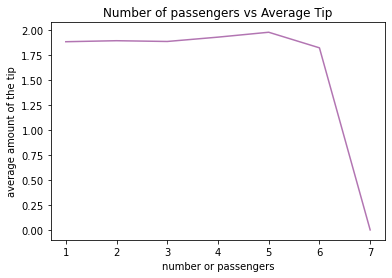

In [22]:
#in order to compare the number of passengers always wrt the amount of the tip, we chose to produce another type of plot, from 
#which we can see that the tip tends to increase if there are more passengers in the taxi, even though there is a slight
#descreasing when the number of passengers is 4

plt.figure()

df.groupby(df.passenger_count).tip_amount.mean().plot(title = 'Number of passengers vs Average Tip',
                                                                xlabel = 'number or passengers',
                                                                ylabel = 'average amount of the tip',
                                                                color = (0.5,0.1,0.5,0.6))

plt.show()

### Speed vs Tip Amount

In [23]:
#drop time_distance==0

df = df[df.time_distance != 0]

In [24]:
# df1 = df1[df1.trip_distance ]

In [25]:
#calculate the speed in miles per hour ->  1 mile/s = 3600 miles/hour

df['speed'] = ((df.trip_distance) / (df.time_distance))*3600

#check
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,time_distance,speed
0,2020-01-21 18:48:44,2020-01-21 19:08:40,2.0,4.80,1.0,0.0,2.0,0.00,22.80,1196,14.448161
1,2020-01-12 04:08:39,2020-01-12 04:10:16,1.0,0.57,1.0,1.0,1.0,0.00,7.30,97,21.154639
2,2020-01-27 12:12:33,2020-01-27 12:21:34,1.0,0.90,1.0,1.0,1.0,1.00,11.30,541,5.988909
3,2020-01-31 09:55:46,2020-01-31 10:07:18,1.0,1.80,1.0,1.0,1.0,1.00,13.80,692,9.364162
4,2020-01-14 23:51:36,2020-01-14 23:58:55,2.0,1.37,1.0,1.0,1.0,2.26,13.56,439,11.234624


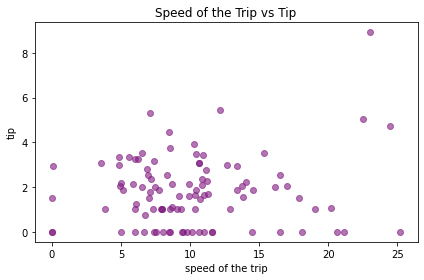

In [26]:
#compare the trend of the speed of the trip wrt the amount of the tip

plt.figure()
plt.scatter(df.speed[0:100], df.tip_amount[0:100], color = (0.5,0.1,0.5,0.6))
plt.title('Speed of the Trip vs Tip')
plt.xlabel('speed of the trip')
plt.ylabel('tip')
plt.tight_layout()
plt.show()

In [27]:
df["speed"] = pd.to_numeric(df["speed"])

In [28]:
print('The correlation between the speed and the amount of the tip is '+ str(round(np.corrcoef(df['speed'], \
df['tip_amount'])[0][1], 2)))

The correlation between the speed and the amount of the tip is 0.06


The correlation between the speed and the amount of the tip is 0.01

Time slot vs Tip amount

The Time slots we are referring to are

1) 06:00 - 10:00

2) 10:00 - 18:00

3) 18:00 - 22:00

4) 22:00 - 06:00

In [29]:
df['pickup_hour'] = df.tpep_pickup_datetime.apply(lambda x: x.hour)

In [30]:
cl_f = {1: 4,  2: 4, 2: 4, 3: 4,  4: 4,  5: 4, 6: 1,  7: 1,   8: 1,  9: 1,  10: 2, 11: 2, 12: 2, \
       13: 2, 14: 2, 15: 2, 16: 2, 17: 2 , 18: 3, 19: 3, 20: 3, 21: 3, 22: 4, 23: 4, 0: 4}

df['time_slot'] = df['pickup_hour'].map(cl_f)

#check
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,time_distance,speed,pickup_hour,time_slot
0,2020-01-21 18:48:44,2020-01-21 19:08:40,2.0,4.80,1.0,0.0,2.0,0.00,22.80,1196,14.448161,18,3
1,2020-01-12 04:08:39,2020-01-12 04:10:16,1.0,0.57,1.0,1.0,1.0,0.00,7.30,97,21.154639,4,4
2,2020-01-27 12:12:33,2020-01-27 12:21:34,1.0,0.90,1.0,1.0,1.0,1.00,11.30,541,5.988909,12,2
3,2020-01-31 09:55:46,2020-01-31 10:07:18,1.0,1.80,1.0,1.0,1.0,1.00,13.80,692,9.364162,9,1
4,2020-01-14 23:51:36,2020-01-14 23:58:55,2.0,1.37,1.0,1.0,1.0,2.26,13.56,439,11.234624,23,4


In [31]:
df_tr = df.sample(frac=0.8, random_state=600)
df_tr.to_csv('./final1_df.csv')

In [32]:
df_te = df.sample(frac=0.2, random_state=600)
df_te.to_csv('./final2_df.csv')

In [33]:
df.groupby(df.time_slot).tip_amount.mean()

time_slot
1    1.822891
2    1.839894
3    2.016784
4    1.978927
Name: tip_amount, dtype: float64

PULocationID & DOLocationID vs Tip amount

In [34]:
df.groupby(df.PULocationID).tip_amount.mean()

PULocationID
0.0    1.698306
1.0    1.890708
Name: tip_amount, dtype: float64

In [35]:
df.groupby(df.DOLocationID).tip_amount.mean()

DOLocationID
0.0    3.024844
1.0    1.796275
2.0    3.423464
Name: tip_amount, dtype: float64

Time distance vs Tip amount

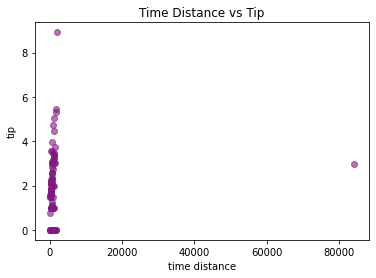

In [36]:
#compare the trend of the time distance travelled wrt the amount of the tip

plt.figure()
plt.scatter(df.time_distance[0:100], df.tip_amount[0:100], color = (0.5,0.1,0.5,0.6))
plt.title('Time Distance vs Tip')
plt.xlabel('time distance')
plt.ylabel('tip')
plt.show()

In [37]:
df["time_distance"] = pd.to_numeric(df["time_distance"])

In [38]:
print('The correlation between the time distance and the amount of the tip is '+ str(round(np.corrcoef(df['time_distance'], \
df['tip_amount'])[0][1], 2)))

The correlation between the time distance and the amount of the tip is 0.03


#### Payment type vs Tip_amount

In [39]:
df.groupby(df.payment_type).tip_amount.mean()

payment_type
1.0    2.574956
2.0    0.000068
Name: tip_amount, dtype: float64

From this analysis we conclude that the useful feature we could use in order to predict the amount of the tip given by a passenger after a taxi ride in NYC are:

passenger_count

trip_distance

PULocationID

payment_type

total_amount

time_slot

DOLocationID

PULocationID

## Analysis of features for Logistic Regression

Goals the goal of this task is to create a model capable of predicting the starting district of a taxi ride, classifying Brooklyn as 0 and Manhattan as 1.

Before going into the model, our intention is to study the relationships between the different features that could serve us and, in fact, the starting district. In this way, we will try to understand what the trends are and what result our model should tend to predict, under certain conditions.

In addition to doing this, we need to structure our features so that they are linearly linked to the output. (example: taken into consideration n significant features, for values greater than a certain moving threshold in the n features, the model will have to predict success, understood as 1, Manhattan.) Therefore, model the values of the features so that the higher ranges are associated with Manhattan, while the lower value ranges in Brooklyn.

#### Let's analyze tra Class of our dataset

In [40]:
print(len(df[df.PULocationID == 0]))
print(len(df[df.PULocationID == 1]))

661
80259


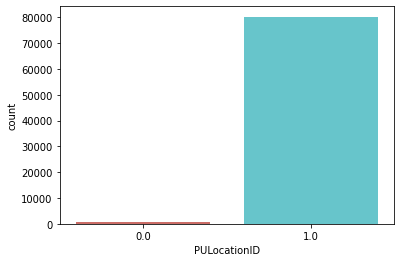

In [41]:
sns.countplot(x='PULocationID', data = df , palette= 'hls')
plt.show()

Our dataset is strongly unbalanced, so we need to modify it in order to make our model more accurated

In [42]:
brooklyn = (len(df[df.PULocationID == 0]))
manhattan = (len(df[df.PULocationID == 1]))
pct_of_manhattan = manhattan / (brooklyn + manhattan)
print("percentage of Manhattan is", pct_of_manhattan*100)

pct_of_brooklyn = brooklyn/(brooklyn + manhattan)
print("percentage of Brooklyn", pct_of_brooklyn*100)

percentage of Manhattan is 99.1831438457736
percentage of Brooklyn 0.8168561542263965


In [43]:
df_M = df[df.PULocationID == 1].sample(n = 661)
df_B = df[df.PULocationID == 0]

In [44]:
df = pd.concat([df_M, df_B], axis=0, sort=False)

#check
df.groupby(df.PULocationID).count()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,DOLocationID,payment_type,tip_amount,total_amount,time_distance,speed,pickup_hour,time_slot
PULocationID,,,,,,,,,,,,
0.0,661,661,661,661,661,661,661,661,661,661,661,661
1.0,661,661,661,661,661,661,661,661,661,661,661,661


In [45]:
df.reset_index(drop=True, inplace=True)

### Time distance vs PULocationID

### Pre-consideration

We want to explore the relationship between the time_distance and PULocationID, in order to understand if this feature can be useful for our model and how is better placing the threshold

In [46]:
df.groupby(df.PULocationID).tip_amount.mean()

PULocationID
0.0    1.698306
1.0    1.959440
Name: tip_amount, dtype: float64

PULocationID
0.0    1756.682300
1.0     927.476551
Name: time_distance, dtype: float64


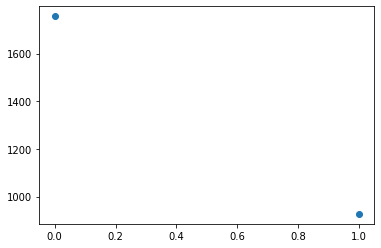

In [47]:
mean_time = df.groupby(df.PULocationID).time_distance.mean()
print(mean_time)
plt.scatter([0,1] ,mean_time )

The average time passed in the taxy, for passengers, is bigger when they take it from Brooklyn (0)

This it means that our logistic model should predict the target Brooklyn when the values of time_distance are higher than a threshold

## Passeger count vs PULocationID
#### Pre-consideration

We want to explore the relationship between the passenger_count and PULocation, in order to understand if this feature can be useful for our model and how is better placing the threshold

In [48]:
mean_pass = df.groupby(df.PULocationID).passenger_count.mean()
print(mean_pass)
#plt.scatter([0,1] ,mean_pass )

PULocationID
0.0    1.350983
1.0    1.511346
Name: passenger_count, dtype: float64


<AxesSubplot:>

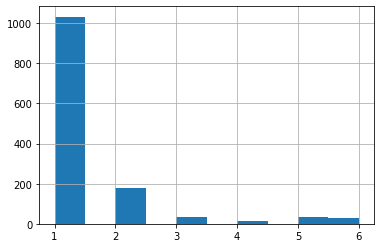

In [49]:
df.passenger_count.hist()

The feature passenger_count has all the value concentrated near 1, and the mean relative to Brooklyn and Manhattan does not change in a meaningful way. This let us think that this feature in not meaningful for the purpose of our model

### Payment type vs PULocationID

In [50]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,time_distance,speed,pickup_hour,time_slot
0,2021-07-25 08:29:28,2021-07-25 08:43:16,2.0,2.45,1.0,1.0,1.0,3.06,18.36,828,10.652174,8,1
1,2020-11-16 01:06:38,2020-11-16 01:08:43,1.0,0.18,1.0,1.0,1.0,1.46,8.76,125,5.184000,1,4
2,2021-04-20 13:53:49,2021-04-20 14:16:05,1.0,7.53,1.0,1.0,2.0,0.00,28.30,1336,20.290419,13,2
3,2020-10-13 16:08:16,2020-10-13 16:13:58,1.0,0.86,1.0,1.0,1.0,2.06,12.36,342,9.052632,16,2
4,2020-01-30 21:02:50,2020-01-30 21:33:09,1.0,6.04,1.0,0.0,2.0,0.00,27.80,1819,11.953821,21,3


<AxesSubplot:xlabel='payment_type'>

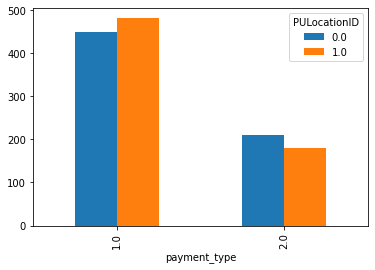

In [51]:
pd.crosstab(df.payment_type,df.PULocationID).plot(kind='bar')

In [52]:
br = df[df.PULocationID == 0]
mnh = df[df.PULocationID == 1]

l1_br = len(br[br.payment_type == 1])
l2_br= len(br[br.payment_type == 2])

pct_of_l1_b = l1_br/(l1_br+l2_br)
pct_of_l2_b = l2_br/(l1_br+l2_br)

print("percentage of payment_type 1, on brooklyn runs is", pct_of_l1_b*100)
print("percentage of payment_type 2, on brooklyn runs is", pct_of_l2_b*100)

percentage of payment_type 1, on brooklyn runs is 68.07866868381241
percentage of payment_type 2, on brooklyn runs is 31.921331316187597


In [53]:
br = df[df.PULocationID == 0]
mnh = df[df.PULocationID == 1]

l1_mnh = len(mnh[mnh.payment_type == 1])
l2_mnh= len(mnh[mnh.payment_type == 2])

pct_of_l1_m = l1_mnh/(l1_mnh+l2_mnh)
pct_of_l2_m = l2_mnh/(l1_mnh+l2_mnh)

print("percentage of payment_type 1, on manhattan runs is", pct_of_l1_m*100)
print("percentage of payment_type 2, on manhattan runs is", pct_of_l2_m*100)

percentage of payment_type 1, on manhattan runs is 72.76853252647504
percentage of payment_type 2, on manhattan runs is 27.23146747352496


As we can see, the percentage of type payment 1 is higher in the Brooklyn runs, this let us think that when the payment is done by type '1', the probability that the departure borough is "Brooklyn" is higher

We now compare the tip_amount, total_amount and trip_distance with the PULocationID in order to find out which of this features is usefull for the logistic regression. For this purpose we look at the mean of these features related to Manhattan (1) and Brooklyn (0)

### tip_amount vs PULocationID

In [54]:
df.groupby(df.PULocationID).tip_amount.mean()

PULocationID
0.0    1.698306
1.0    1.959440
Name: tip_amount, dtype: float64

The difference between the two values is not significant, in fact the ratio of the two is equal to

In [55]:
df.groupby(df.PULocationID).tip_amount.mean()[1]/df.groupby(df.PULocationID).tip_amount.mean()[0]

1.1537618699780863

which is not enough high. Instead we are looking for ratio values greater or equal 1.5

### total_amount vs PULocationID

In [56]:
df.groupby(df.PULocationID).total_amount.mean()

PULocationID
0.0    24.200303
1.0    15.712239
Name: total_amount, dtype: float64

In [57]:
df.groupby(df.PULocationID).total_amount.mean()[0]/df.groupby(df.PULocationID).total_amount.mean()[1]

1.5402198580945694

### trip_distance vs PULocationID

In [58]:
df.groupby(df.PULocationID).trip_distance.mean()

PULocationID
0.0    3.701543
1.0    2.248064
Name: trip_distance, dtype: float64

Ratio:

In [59]:
df.groupby(df.PULocationID).trip_distance.mean()[0]/df.groupby(df.PULocationID).trip_distance.mean()[1]

1.646547373096361

So in the end the two features which is meaningful to take are total_amount and trip_distance

From this analysis we conclude that the useful feature we could use in order to predict the departure borough of a taxi ride in NYC are:

time_distance

payment_type

total_amount

trip_tristance

## Linear Regression Model

To create our Linear Regression Model we use passenger_count, trip_distance, PULocationID, payment_type, total_amount, time_slot features.

#### Let's adapt the dataset to our purpose!

In [60]:
df1 = pd.read_csv('final2_df.csv')

In [61]:
print(len(df1))

16184


In [62]:
columns = ['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'total_amount', 'time_slot', 'tip_amount']
df = df1[columns]

In [63]:
df.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,time_slot,tip_amount
0,2.0,1.10,1.0,1.0,2.0,10.30,3,0.00
1,1.0,3.90,1.0,1.0,1.0,23.15,2,3.85
2,2.0,1.10,1.0,1.0,2.0,9.30,2,0.00
3,1.0,0.70,1.0,1.0,2.0,4.80,1,0.00
4,1.0,2.01,1.0,1.0,2.0,16.80,2,0.00


In [65]:
df1.drop('Unnamed: 0', axis = 1, inplace = True)
df1.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,time_distance,speed,pickup_hour,time_slot
0,2021-03-27 20:46:22,2021-03-27 20:53:27,2.0,1.10,1.0,1.0,2.0,0.00,10.30,425,9.317647,20,3
1,2021-01-12 12:43:02,2021-01-12 13:01:34,1.0,3.90,1.0,1.0,1.0,3.85,23.15,1112,12.625899,12,2
2,2021-04-20 10:21:39,2021-04-20 10:27:47,2.0,1.10,1.0,1.0,2.0,0.00,9.30,368,10.760870,10,2
3,2020-05-06 07:07:20,2020-05-06 07:09:25,1.0,0.70,1.0,1.0,2.0,0.00,4.80,125,20.160000,7,1
4,2020-11-03 10:55:31,2020-11-03 11:16:12,1.0,2.01,1.0,1.0,2.0,0.00,16.80,1241,5.830782,10,2


In [66]:
df1.isnull().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
tip_amount               0
total_amount             0
time_distance            0
speed                    0
pickup_hour              0
time_slot                0
dtype: int64

In [67]:
df1['speed'].fillna(0, inplace = True)

In [68]:
scaler = StandardScaler()

In [69]:
df_sc = scaler.fit_transform(df.iloc[:, :7])

In [70]:
df.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,time_slot,tip_amount
0,2.0,1.10,1.0,1.0,2.0,10.30,3,0.00
1,1.0,3.90,1.0,1.0,1.0,23.15,2,3.85
2,2.0,1.10,1.0,1.0,2.0,9.30,2,0.00
3,1.0,0.70,1.0,1.0,2.0,4.80,1,0.00
4,1.0,2.01,1.0,1.0,2.0,16.80,2,0.00


In [71]:
lr = LinearRegression()

### Normalization of the features in order to have an homogeneous range.

In [72]:
passenger_sc = (df['passenger_count'] -np.mean(df['passenger_count'])) / np.std(df['passenger_count'])
df['passenger_count'] = passenger_sc

In [73]:
distance_sc = (df['trip_distance'] -np.mean(df['trip_distance'])) / np.std(df['trip_distance'])
df['trip_distance'] = distance_sc

In [74]:
total_sc = (df['total_amount'] -np.mean(df['total_amount'])) / np.std(df['total_amount'])
df['total_amount'] = total_sc

In [75]:
tip_sc = (df['tip_amount'] -np.mean(df['tip_amount'])) / np.std(df['tip_amount'])
df['tip_amount'] = tip_sc

In [76]:
df.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,time_slot,tip_amount
0,0.513064,-0.481538,1.0,1.0,2.0,-0.600357,3,-0.685562
1,-0.431796,0.670075,1.0,1.0,1.0,0.774339,2,0.700900
2,0.513064,-0.481538,1.0,1.0,2.0,-0.707337,2,-0.685562
3,-0.431796,-0.646054,1.0,1.0,2.0,-1.188748,1,-0.685562
4,-0.431796,-0.107264,1.0,1.0,2.0,0.095015,2,-0.685562


### Split dataset in training and test sets.

In [77]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 0:7], df['tip_amount'], test_size = 0.3, random_state = 12345)

In [78]:
len(x_train)

11328

In [79]:
len(x_test)

4856

In [80]:
len(y_train)

11328

In [81]:
len(y_test)

4856

In [82]:
lr.fit(x_train, y_train)

LinearRegression()

In [83]:
pred = lr.predict(x_test)
pred

array([ 0.07444125, -0.07301855, -0.87650496, ..., -0.10888802,
        1.13886084, -0.57334507])

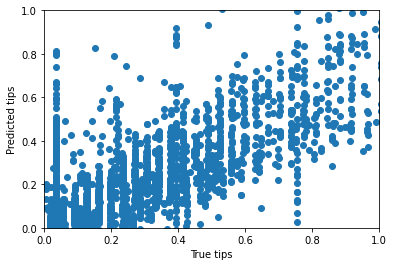

In [84]:
#plot relationship between true and predicted tips
plt.scatter(y_test, pred)
plt.xlabel('True tips')
plt.ylabel('Predicted tips')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

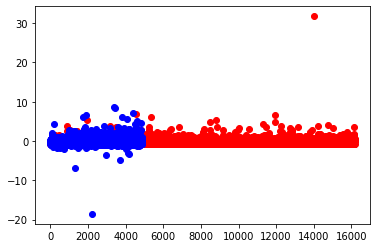

In [85]:
plt.plot(y_test, 'ro')
plt.plot(pred, 'ro', color = 'blue')
plt.show()

In [86]:
coeff = pd.DataFrame(lr.coef_, df.columns[0:7], columns=['coeff'])
coeff

,coeff
passenger_count,0.004751
trip_distance,-0.451180
PULocationID,0.865711
DOLocationID,-0.006400
payment_type,-0.642949
total_amount,0.880996
time_slot,-0.003667


In [87]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 0.24825021795490676
MSE: 0.3939135536286556
RMSE: 0.6276253290209499


In [88]:
r2 = r2_score(y_test, pred)
r2

0.38760502800535046

## Logistic Regression Analysis

The feautures used to apply Logistic Regression Model are time_distance, payment_type, total_amount and trip_distance.

Adapting dataset.

In [89]:
lr = LogisticRegression()

cl = df['PULocationID'].values

In [90]:
df1.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,tip_amount,total_amount,time_distance,speed,pickup_hour,time_slot
0,2021-03-27 20:46:22,2021-03-27 20:53:27,2.0,1.10,1.0,1.0,2.0,0.00,10.30,425,9.317647,20,3
1,2021-01-12 12:43:02,2021-01-12 13:01:34,1.0,3.90,1.0,1.0,1.0,3.85,23.15,1112,12.625899,12,2
2,2021-04-20 10:21:39,2021-04-20 10:27:47,2.0,1.10,1.0,1.0,2.0,0.00,9.30,368,10.760870,10,2
3,2020-05-06 07:07:20,2020-05-06 07:09:25,1.0,0.70,1.0,1.0,2.0,0.00,4.80,125,20.160000,7,1
4,2020-11-03 10:55:31,2020-11-03 11:16:12,1.0,2.01,1.0,1.0,2.0,0.00,16.80,1241,5.830782,10,2


In [91]:
columns = ['time_distance', 'payment_type', 'total_amount', 'trip_distance']
df2 = df1[columns]
time_distance_sc = (df1['time_distance'] -np.mean(df1['time_distance'])) / np.std(df1['time_distance'])
df2['trip_distance'] = distance_sc
df2['total_amount'] = total_sc
df2['time_distance'] = time_distance_sc

In [92]:
df3= df1[columns]
df3.head()

,time_distance,payment_type,total_amount,trip_distance
0,425,2.0,10.30,1.10
1,1112,1.0,23.15,3.90
2,368,2.0,9.30,1.10
3,125,2.0,4.80,0.70
4,1241,2.0,16.80,2.01


In [93]:
df2.head()

,time_distance,payment_type,total_amount,trip_distance
0,-0.109960,2.0,-0.600357,-0.481538
1,0.069618,1.0,0.774339,0.670075
2,-0.124860,2.0,-0.707337,-0.481538
3,-0.188379,2.0,-1.188748,-0.646054
4,0.103337,2.0,0.095015,-0.107264


### split features in train and test sets

In [94]:
x_train, x_test, y_train, y_test = train_test_split(df2, cl, test_size = 0.3, random_state = 12345)

In [95]:
#We use the LogisticRegression () code to create the logistic regression model.
#we fit the model to the training set using fit (X_train, y_train) and predict on the test set using predict (X_test).

lr.fit(x_train,y_train)
y_pred=lr.predict(x_test)

In [96]:
#To evaluate performance we use the Confusion Matrix.
#The foundation of this matrix is the number of correct (true positive) and incorrect (false positive) predictions 
#summarized in terms of class.
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   0   37]
 [   0 4819]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        37
         1.0       0.99      1.00      1.00      4819

    accuracy                           0.99      4856
   macro avg       0.50      0.50      0.50      4856
weighted avg       0.98      0.99      0.99      4856

